In [1]:
#Import Necessary Library's
import pandas as pd
import numpy as np
import json
from pathlib import Path
import seaborn as sn
import matplotlib.pyplot as pyplot

In [2]:
#Import Data
data_folder = Path("./Data/")

In [3]:
HappinessFile = data_folder / "2019 Happiness Data.csv"

#Import Data to Pandas DataFrame
happinessDF = pd.read_csv(HappinessFile)
happinessDF2 = happinessDF.drop(happinessDF.columns.difference(["Country or region", "Score"]), axis = 1)
happinessDF2.rename(columns = {"Score": "Happiness Score", "Country or region": "Country Name"}, inplace = True)
happinessDF2.set_index("Country Name", inplace = True)

In [4]:
#Import Data
FreedomFile = data_folder / "economic_freedom_index2019_data.csv"

#Import Data to Pandas DataFrame
economicFreedomDF = pd.read_csv(FreedomFile,encoding='latin-1')
economicFreedomDF = economicFreedomDF.dropna(subset=["World Rank"])
#economicFreedomDF2 = economicFreedomDF.drop(economicFreedomDF.columns.difference(["Country Name","2019 Score", "GDP (Billions, PPP)", "GDP per Capita (PPP)","Financial Freedom", "Population (Millions)", "Unemployment (%)", "Inflation (%)"]), axis = 1)
economicFreedomDF2 = economicFreedomDF.drop(economicFreedomDF.columns.difference(["Country Name","2019 Score","Financial Freedom", "Population (Millions)", "Unemployment (%)", "Inflation (%)"]), axis = 1)
economicFreedomDF2.rename(columns = {"2019 Score": "Economic Freedom"}, inplace = True)
economicFreedomDF2.set_index("Country Name", inplace = True)

#economicFreedomDF2["GDP (Billions, PPP)"] = economicFreedomDF2["GDP (Billions, PPP)"].str.replace("$","")
#economicFreedomDF2["GDP (Billions, PPP)"] = economicFreedomDF2["GDP (Billions, PPP)"].str.replace(",","")
#economicFreedomDF2["GDP (Billions, PPP)"] = economicFreedomDF2["GDP (Billions, PPP)"].str.strip()

#economicFreedomDF2["GDP per Capita (PPP)"] = economicFreedomDF2["GDP per Capita (PPP)"].str.replace("$","")
#economicFreedomDF2["GDP per Capita (PPP)"] = economicFreedomDF2["GDP per Capita (PPP)"].str.replace(",","")
#economicFreedomDF2["GDP per Capita (PPP)"] = economicFreedomDF2["GDP per Capita (PPP)"].str.strip()

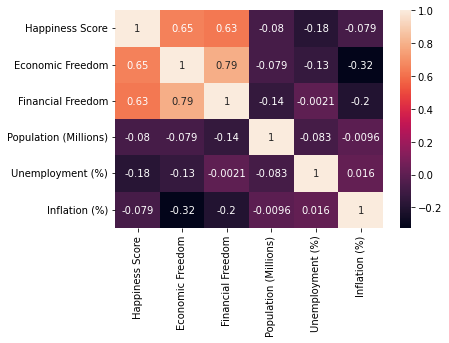

In [5]:
df = happinessDF2.join(economicFreedomDF2, on = 'Country Name', how = "inner")
df = df.astype(float)
corrMatrix = df.corr(method = "pearson")
sn.heatmap(corrMatrix, annot=True)
pyplot.show()

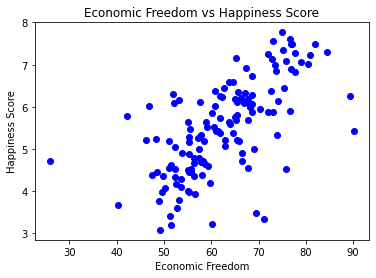

In [6]:
pyplot.plot(df["Economic Freedom"],df["Happiness Score"], "bo")
pyplot.xlabel("Economic Freedom")
pyplot.ylabel("Happiness Score")
pyplot.title("Economic Freedom vs Happiness Score")
pyplot.show()

In [7]:
x = df["Economic Freedom"]
y = df["Happiness Score"]

A = np.vstack([x, np.ones(len(x))]).T

In [8]:
betahat_1, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
betahat_1, intercept

(0.07028559065783405, 1.0974685872596073)

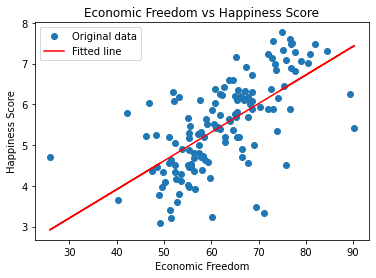

In [9]:
_ = pyplot.plot(x, y, 'o', label='Original data')
_ = pyplot.plot(x, betahat_1*x + intercept, 'r', label='Fitted line')
_ = pyplot.xlabel("Economic Freedom")
_ = pyplot.ylabel("Happiness Score")
_ = pyplot.title("Economic Freedom vs Happiness Score")
_ = pyplot.legend()
pyplot.show()

Below is the old way we were importing data. Keeping it in case new way does not work.

In [ ]:
#fileName = "./Data/2019 Happiness Data.csv"
#happinessDF = pd.read_csv(fileName) 

#fileName = "./Data/economic_freedom_index2019_data.csv"
#economicFreedomDF = pd.read_csv(fileName,encoding='latin-1')


#json_file = open("countries.geo.json", "r")
#countries_geojson = json.load(json_file)

#json_file = open("factbook-country-profiles.json", "r")
#factbook = json.loads(json.dumps("factbook-country-profiles.json"))

In [ ]:
factbook-country-profiles.json = factbook-country-profiles.json.replace("\'", "\"")
json_file = open("factbook-country-profiles.json", "r")
factbook = json.load(json_file)

In [ ]:
factbook = json.loads(json.dumps("factbook-country-profiles.json"))

In [ ]:
String exampleRequest = FileUtils.readFileToString(new File("exampleJsonRequest.json"), StandardCharsets.UTF_8);
factbook

In [ ]:
json.load(json_file)